In [1]:
from ExoTransit import environ
# currently allowed options are qt5 and notebook. Qt5 is preferred
# for better visualization.
environ['mpl_backend'] = 'qt5'  
from ExoTransit.retrieve import model_transit_lightcurve, test_func
import numpy as np
import matplotlib.pyplot as plt
import os
if os.path.basename(os.getcwd())!='testdata':
    os.chdir('testdata')

# Simulated transit data
Read a simulated transit light curve in the 'run2learn/testdata' directory. fmod is the pure light curve whrefrom, f is obtained by adding random noise to fmod. Thecorresponding error is e.

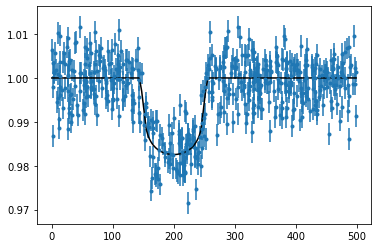

In [12]:
%matplotlib inline
file = 'simdata'
t,f,e,fmod = np.loadtxt(file, unpack=True)
plt.errorbar(t,f,e, fmt='.')
plt.plot(t,fmod,'k')

# Setting up the parameters 
'parnames' are the names of the free (or fixed) parameters and  should be exactly as mentioned below. Otherwise, the code will
not be able to identify the parameters. 'parlabelnames' are used
for labeling the plots as shown in the following cell.

N.B.: Both initial guess and boundaries are required for each free
parameter.

In [2]:
parlabelnames = ['tcen', 'b', 'Rs/a', 'Rp/Rs', 'fout', 'C2', 'C4']
parnames = ['tcen', 'b', 'rsa', 'rprs', 'fout', 'c2', 'c4']
par0 = [190, 0.1, 0.2, 0.2, 0.98, 0.4, 0.3]
bounds = [(170, 220), (0, 0.5), (0.1, 0.3), (0.1, 0.3), (0.96, 1.06), (0.3, 0.5), (0.25, 0.35)]
par = dict(zip(parnames, par0)) # to get in {name: value} fashion.
bounds = dict(zip(parnames, bounds)) # to get in {name: (lower_bound, upper_bound)} fashion.

# Run MCMC and monitor progress
Add data or datafile and run. Period is fixed. Currently, period
cannot be set as a free parameter. 'mcmc_name' only is helpful
in idetifying the figure windows in case the monitor option is 
selected, otherwise can be skipped or set as '' (empty).

The monitor argument can be left [] for no visualization, or be set as a list of monitor opyions. The allowed options are 'corner', 'walkerprogress' and 'autocorrtime' (see __README__ for reference). You can set monitor='all' to visualize all three.

In [3]:
%matplotlib qt5 # must be same as ExoTransit.environ['mpl_backend']
mlc = model_transit_lightcurve()
mlc.per = 1.5 * 1440
mlc.add_data(file, par, bounds, usecols=(0, 1, 2))
mlc.run_mcmc(mcmc_name='sim', Nwalker=100, Niterate=1000, monitor='all', checkconvergence=True, showprogress=True)

:: MCMCWarning: Not enough number of iteration compared to checkstep. It is suggested to increase the value of Niterate
100%|██████████| 1000/1000 [09:17<00:00,  1.79it/s]


# Observe the chain through plots
This will help you decide the initial portion of the chain to be burned. I have shown the walker-progress and the corner plots of the final unflattened chain. Here, the 'parlabelnames' list has been used to label the plots.

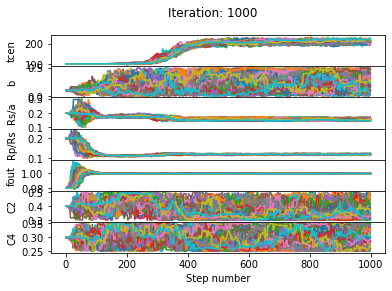

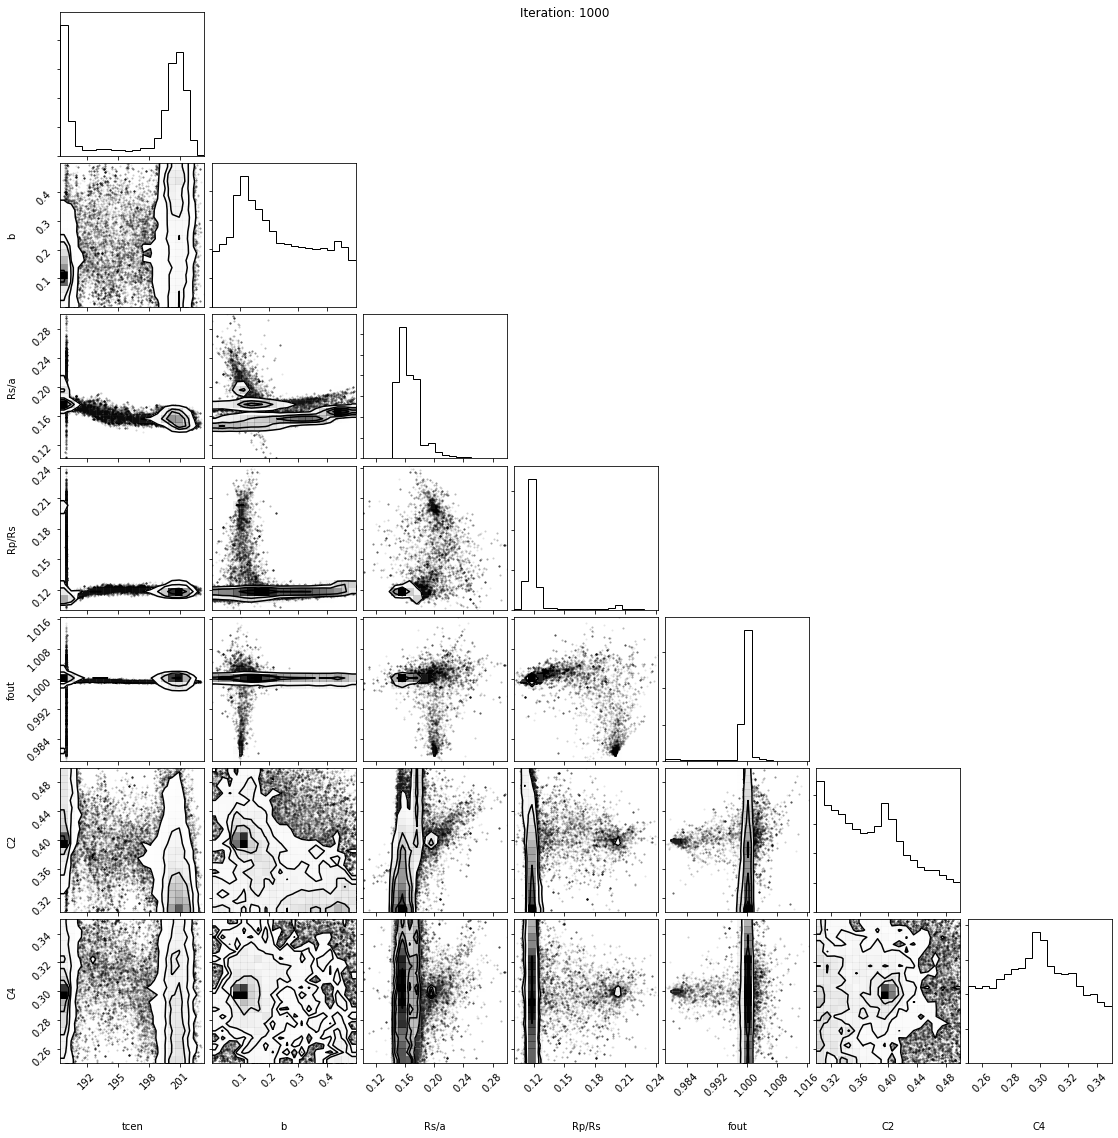

In [16]:
%matplotlib inline
_ = mlc.mcmc.show_walker_progress(labels=parlabelnames)
_ = mlc.mcmc.show_corner(labels=parlabelnames)

# Check and save results

First get the sample chain flattened, the final chain shape will be (walker_no. x iteration_no., free_parameter_no.). You can save the entire structure of the process in a pickle file and load it in future for further study. Also, the final flattened MCMC chain can be saved to a file for further use. 

The last step is to calculate the median and 1-sigma errorbar of each parameter. You may save the values to a file.

In [13]:
mlc.get_flatsamples(burn=600)
mlc.saveall(retrieval_skeleton=file+'_skel', params_mcmc=file+'_allmcmcsamples')
mlc.save_median_err_params_mcmc(saveto=file + '_params_mcmc', display=True)

(7, 3)
tcen: 200.90949108016378 +0.7460277060352212 -0.793465788206106
b: 0.27670950418780643 +0.16233116404629216 -0.18260557905647162
rsa: 0.15448878024810983 +0.009637450967548367 -0.005828332732308483
rprs: 0.11969308536062709 +0.001875456185129562 -0.001812266063089124
fout: 0.9994735413162977 +0.00013033185643784861 -0.00012418284846837935
c2: 0.339381134791117 +0.05883100371664546 -0.030033812726051823
c4: 0.2947367293937318 +0.03461197883217587 -0.0310612545681464


# Final plot of the model

overplot the model corresponding to the median values of the parameters on the erorbar plot of the original data to visually assess the results.

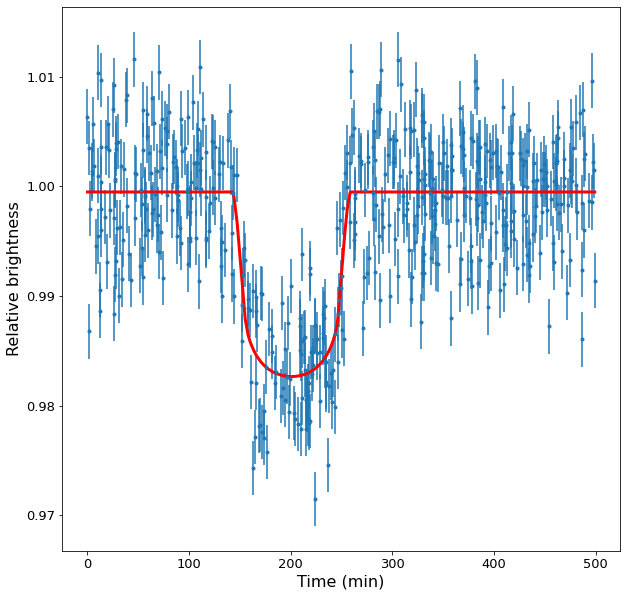

In [11]:
%matplotlib inline
_, ax = mlc.overplot_model_median_err_params_mcmc()
ax.set_ylabel('Relative brightness', size=16)
ax.set_xlabel('Time (min)', size=16)
ax.tick_params(labelsize=13)